# Convolutional Neural Networks in hls4ml

In this notebook you will learn how to train a pruned and quantized convolutional neural network (CNN) and deploy it using hls4ml. For this exercise, we will use the Street View House Numbers (SVHN) Dataset (http://ufldl.stanford.edu/housenumbers/).

The SVHN dataset consists of real-world images of house numbers extracted from Google Street View images. The format is similar to that of the MNIST dataset, but is a much more challenging real-world problem, as illustrated by the examples shown below.

All the images are in RGB format and have been cropped to 32x32 pixels. 
Unlike MNIST, more than one digit can be present in the same image and in these cases, the center digit is used to assign a label to the image.
Each image can belong to one of 10 classes, corresponding to digits 0 through 9.

![alt text](images/test.png "SVHN examples from the test dataset")

The SVHN dataset consists of 73,257 images for training (and 531,131 extra samples that are easier to classify and can be used as additional training data) and 26,032 images for testing.

### Start with the neccessary imports

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
AUTO = tf.data.experimental.AUTOTUNE
import tensorflow_datasets as tfds

### Fetch the SVHN dataset using Tensorflow Dataset

In this part we will fetch the trainining, validation and test dataset using Tensorflow Datasets (https://www.tensorflow.org/datasets). We will not use the 'extra' training in order to save time, but you could fetch it by adding `split='train[:90%]+extra'`. We will use the first 90% of the training data for training and the last 10% for validation.

In [9]:
ds_train, info = tfds.load('svhn_cropped', split='train[:90%]', with_info=True, as_supervised=True)
ds_test        = tfds.load('svhn_cropped', split='test', shuffle_files=True, as_supervised=True)
ds_val         = tfds.load('svhn_cropped', split='train[-10%:]', shuffle_files=True, as_supervised=True)

assert isinstance(ds_train, tf.data.Dataset)
train_size  = int(info.splits['train'].num_examples)
input_shape = info.features['image'].shape 
n_classes    = info.features['label'].num_classes 

print('Training on {} samples of input shape {}, belonging to {} classes'.format(train_size,input_shape,n_classes))

Training on 73257 samples of input shape (32, 32, 3), belonging to 10 classes


We'll use TensorFlow Dataset to prepare our datasets. We'll fetch the training dataset as tuples, and the test dataset as numpy arrays

In [ ]:
def preprocess(image, label,nclasses=10):
  image = tf.cast(image, tf.float32) / 255.
  label = tf.one_hot(tf.squeeze(label), nclasses)
  return image, label

In [10]:
batch_size = 1024
epochs = 20

train = ds_train.map(preprocess,n_classes) #Get dataset as image and one-hot encoded labels, divided by max RGB    
train = train.repeat()
train = train.batch(batch_size) # Prepare batches
train = train.prefetch(AUTO) # Allows later elements to be prepared while the current element is being processed

val = ds_val.map(preprocess,n_classes)    
val = val.batch(batch_size)
val = val.prefetch(AUTO)

#For  testing, we get the full dataset as numpy arrays to have access to labels and images separately
X_test, Y_test = tfds.as_numpy(tfds.load('svhn_cropped',split='test',batch_size=-1,as_supervised=True,))
X_test, Y_test = preprocess(X_test, Y_test,nclasses=n_classes)
print("X_test type = {} , X_test shape = {} ".format(type(X_test), X_test.shape))

X_test type = <class 'tensorflow.python.framework.ops.EagerTensor'> , X_test shape = (26032, 32, 32, 3) 


### Defining the model

We then need to define a model. For the lowest possible latency, each layer should have a maximum number of trainable parameters of 4096. This is due to fixed limits in the Vivado compiler, beyond which maximally unrolled (=parallel) compilation will fail. This will allow us to use `strategy = 'latency'` in the hls4ml part, rather than `strategy = 'resource'`, in turn resulting in lower latency

In [11]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense

from tensorflow.keras.models import Model

filters_per_conv_layer = [16,16,24]
neurons_per_dense_layer = [42,64]

x = x_in = Input(input_shape)
x = BatchNormalization()(x)
for i,f in enumerate(filters_per_conv_layer):
    print( ('Adding convolutional block {} with N={} filters').format(i,f) )
    x = Conv2D(int(f), kernel_size=(3,3), strides=(1,1), kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), use_bias=False,
               name='conv_{}'.format(i))(x) 
    x = BatchNormalization()(x)
    x = Activation('relu',name='conv_act_%i'%i)(x)
    x = MaxPooling2D(pool_size = (2,2) )(x)
x = Flatten()(x)
for i,n in enumerate(neurons_per_dense_layer):
  print( ('Adding dense block {} with N={} neurons').format(i,n) )
  x = Dense(n,kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001),name='dense_%i'%i, use_bias=False)(x)
  x = BatchNormalization()(x)
  x = Activation('relu',name='dense_act_%i'%i)(x)
x = Dense(int(n_classes),name='output_dense')(x)
x_out = Activation('softmax',name='output_softmax')(x)
model = Model(inputs=[x_in], outputs=[x_out], name='keras_baseline')

model.summary()

Adding convolutional block 0 with N=16 filters
Adding convolutional block 1 with N=16 filters
Adding convolutional block 2 with N=24 filters
Adding dense block 0 with N=42 neurons
Adding dense block 1 with N=64 neurons
Model: "keras_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32, 32, 3)         12        
_________________________________________________________________
conv_0 (Conv2D)              (None, 30, 30, 16)        432       
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 16)        64        
_________________________________________________________________
conv_act_0 (Activation)      (None, 30, 30, 16)        0         
_______________________________

Lets check if this model can be implemented completely parallel

In [12]:
for layer in model.layers:
    if layer.__class__.__name__ in ['Conv2D', 'Dense']:
        w = layer.get_weights()[0]
        layersize = np.prod(w.shape)
        print("{}: {}".format(layer.name,layersize)) # 0 = weights, 1 = biases
        if (layersize > 4096): # assuming that shape[0] is batch, i.e., 'None'
           print("Layer {} is too large ({}), are you sure you want to train?".format(layer.name,layersize))

conv_0: 432
conv_1: 2304
conv_2: 3456
dense_0: 4032
dense_1: 2688
output_dense: 640


Looks good! It's below the Vivado-enforced unroll limit of 4096.

### Prune dense and covolutional layers
Since we've seen in the previous notebooks that pruning can be done at no accuracy cost, let's prune the convolutional and dense layers to 50% sparsity, skipping the output layer

In [13]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks

def pruneFunction(layer):
    pruning_params = {'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.0,final_sparsity=0.50, begin_step=0, end_step=1000, frequency=50)}
    if isinstance(layer, tf.keras.layers.Conv2D):
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
    if isinstance(layer, tf.keras.layers.Dense) and layer.name!='output_dense':
      return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)  
    return layer

model_pruned = tf.keras.models.clone_model( model, clone_function=pruneFunction)

### Train the model

We're now ready to train the model! We defined the batch size and n epochs above.

In [14]:
import time

steps_per_epoch      = int(train_size*0.9)  // batch_size #90% train, 10% validation in 10-fold xval
eval_steps_per_epoch = int(train_size*0.1) //  batch_size

print('N training steps per epoch is {}'.format(steps_per_epoch))

LOSS        = tf.keras.losses.CategoricalCrossentropy()
OPTIMIZER   = tf.keras.optimizers.Adam(learning_rate=3E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True) 
model_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
            tf.keras.callbacks.ModelCheckpoint('pruned_cnn_model_best.h5',monitor="val_loss",verbose=0,save_best_only=True), 
            tf.keras.callbacks.ModelCheckpoint('pruned_cnn_weights_best.h5',monitor="val_loss",verbose=0,save_weights_only=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6),
            pruning_callbacks.UpdatePruningStep()
            ]      

start = time.time()
history = model_pruned.fit(train,
                      epochs =  epochs,
                      validation_data = val,
                      callbacks = callbacks,
                      steps_per_epoch = steps_per_epoch,  
                      verbose=1)     
end = time.time()
print('\n It took {} minutes to train!\n'.format( (end - start)/60.))

model_pruned.load_weights('pruned_cnn_weights_best.h5')  

N training steps per epoch is 64
Epoch 1/30
64/64 [==============================] - 27s 419ms/step - loss: 1.5542 - accuracy: 0.5200 - val_loss: 2.0396 - val_accuracy: 0.3206
Epoch 2/30
64/64 [==============================] - 26s 409ms/step - loss: 0.7584 - accuracy: 0.8017 - val_loss: 1.4174 - val_accuracy: 0.5560
Epoch 3/30
64/64 [==============================] - 26s 410ms/step - loss: 0.6115 - accuracy: 0.8445 - val_loss: 0.9593 - val_accuracy: 0.7181
Epoch 4/30
64/64 [==============================] - 27s 419ms/step - loss: 0.5496 - accuracy: 0.8613 - val_loss: 0.7231 - val_accuracy: 0.8055
Epoch 5/30
64/64 [==============================] - 27s 423ms/step - loss: 0.5083 - accuracy: 0.8738 - val_loss: 0.6291 - val_accuracy: 0.8342
Epoch 6/30
64/64 [==============================] - 27s 423ms/step - loss: 0.4773 - accuracy: 0.8823 - val_loss: 0.5664 - val_accuracy: 0.8576
Epoch 7/30
64/64 [==============================] - 27s 420ms/step - loss: 0.4562 - accuracy: 0.8874 - val_lo

You'll notice the accuracy is lower than that in the hls4ml CNN paper (https://arxiv.org/abs/2101.05108) despite the model being the same. The reson for this is that we didn't use the ``extra`` training data in order to save time. If you want to futher optimize the network, increasing the training data is a good place to start. Enlarging the model architecture comes at a high latency/resource cost.

### Quantization and the fused Conv2D+BatchNormalization layer in QKeras
Let's now create a pruned an quantized model using QKeras. For this, we will use a fused Convolutional and BatchNormalization (BN) layer from QKeras, which will further speed up the implementation when we implement the model using hls4ml. 
There is currently no fused Dense+BatchNoralization layer available in QKeras, so we'll use Keras BatchNormalization when BN follows a Dense layer for now. We'll use the same precision everywhere, namely a bit width of 6 and 0 integer bits (this will be implemented as``<7,1>`` in hls4ml, due to the missing sign-bit).

In [16]:
from qkeras import QActivation
from qkeras import QDense, QConv2DBatchnorm

x = x_in = Input(input_shape)
x = BatchNormalization()(x)
for i,f in enumerate(filters_per_conv_layer):
    print( ('Adding fused QConv+BN block {} with N={} filters').format(i,f) )
    x = QConv2DBatchnorm(int(f), kernel_size=(3,3), strides=(1,1),
                         kernel_quantizer="quantized_bits(6,0,1)", 
                         bias_quantizer="quantized_bits(6,0,1)",
                         kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001), use_bias=False,
                         name='conv_{}'.format(i))(x) 
    x = QActivation('quantized_relu(6)',name='conv_act_%i'%i)(x)
    x = MaxPooling2D(pool_size = (2,2) )(x)
x = Flatten()(x)
for i,n in enumerate(neurons_per_dense_layer):
  print( ('Adding QDense block {} with N={} neurons').format(i,n) )
  x = QDense(n,
            kernel_quantizer="quantized_bits(6,0,1)",
            kernel_initializer='lecun_uniform', kernel_regularizer=l1(0.0001),name='dense_%i'%i, use_bias=False)(x)
  x = BatchNormalization()(x)
  x = QActivation('quantized_relu(6)',name='dense_act_%i'%i)(x)
x = Dense(int(n_classes),name='output_dense')(x)
x_out = Activation('softmax',name='output_softmax')(x)
qmodel = Model(inputs=[x_in], outputs=[x_out], name='qkeras')

qmodel.summary()
#Print the quantized layers
for layer in qmodel.layers:
    if hasattr(layer, "kernel_quantizer"):
        print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
    elif hasattr(layer, "quantizer"):
        print(layer.name, "quantizer:", str(layer.quantizer))

Adding fused QConv+BN block 0 with N=16 filters
Adding fused QConv+BN block 1 with N=16 filters
Adding fused QConv+BN block 2 with N=24 filters
Adding QDense block 0 with N=42 neurons
Adding QDense block 1 with N=64 neurons
Model: "qkeras"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv_0 (QConv2DBatchnorm)    (None, 30, 30, 16)        497       
_________________________________________________________________
conv_act_0 (QActivation)     (None, 30, 30, 16)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 15, 15, 16)        0         
__________________________________

You see that a bias quantizer is defined, although we are not using a bias term for the layers. This is set automatically by QKeras. In addition, you'll note that ``alpha='auto_po2'``. This sets the weight scale per channel to be a power-of-2, such that an actual hardware implementation can be performed by just shifting the result of the convolutional/dense layer to the right or left by checking the sign of the scale and then taking the log2 of the scale.

Let's now prune and train this model!

In [17]:
qmodel_pruned = tf.keras.models.clone_model( qmodel, clone_function=pruneFunction)

In [18]:
LOSS        = tf.keras.losses.CategoricalCrossentropy()
OPTIMIZER   = tf.keras.optimizers.Adam(learning_rate=3E-3, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True) 
qmodel_pruned.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=["accuracy"])

callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
            tf.keras.callbacks.ModelCheckpoint('quantized_cnn_model_best.h5',monitor="val_loss",verbose=1,save_best_only=True), 
            tf.keras.callbacks.ModelCheckpoint('quantized_cnn_weights_best.h5',monitor="val_loss",verbose=1,save_weights_only=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=2, min_lr=1E-6),
            pruning_callbacks.UpdatePruningStep()
            ]      

start = time.time()
history = qmodel_pruned.fit(train,
                      epochs =  epochs,
                      validation_data = val,
                      callbacks = callbacks,
                      steps_per_epoch = steps_per_epoch,  
                      verbose=1)     
end = time.time()
print('\n It took {} minutes to train!\n'.format( (end - start)/60.))

qmodel_pruned.load_weights('quantized_cnn_weights_best.h5')  

Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 2.1839 - accuracy: 0.2743
Epoch 00001: val_loss improved from inf to 2.28306, saving model to quantized_cnn_model_best.h5

Epoch 00001: saving model to quantized_cnn_weights_best.h5
64/64 [==============================] - 56s 872ms/step - loss: 2.1839 - accuracy: 0.2743 - val_loss: 2.2831 - val_accuracy: 0.2969
Epoch 2/30
64/64 [==============================] - ETA: 0s - loss: 1.3395 - accuracy: 0.5993
Epoch 00002: val_loss improved from 2.28306 to 1.88348, saving model to quantized_cnn_model_best.h5

Epoch 00002: saving model to quantized_cnn_weights_best.h5
64/64 [==============================] - 55s 857ms/step - loss: 1.3395 - accuracy: 0.5993 - val_loss: 1.8835 - val_accuracy: 0.3653
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 0.9230 - accuracy: 0.7455
Epoch 00003: val_loss improved from 1.88348 to 1.35040, saving model to quantized_cnn_model_best.h5

Epoch 00003: saving model to quantize

64/64 [==============================] - ETA: 0s - loss: 0.3786 - accuracy: 0.9043
Epoch 00023: val_loss did not improve from 0.49494

Epoch 00023: saving model to quantized_cnn_weights_best.h5
64/64 [==============================] - 57s 895ms/step - loss: 0.3786 - accuracy: 0.9043 - val_loss: 0.5069 - val_accuracy: 0.8710
Epoch 24/30
64/64 [==============================] - ETA: 0s - loss: 0.3780 - accuracy: 0.9049
Epoch 00024: val_loss did not improve from 0.49494

Epoch 00024: saving model to quantized_cnn_weights_best.h5
64/64 [==============================] - 51s 800ms/step - loss: 0.3780 - accuracy: 0.9049 - val_loss: 0.5185 - val_accuracy: 0.8675
Epoch 25/30
64/64 [==============================] - ETA: 0s - loss: 0.3766 - accuracy: 0.9053
Epoch 00025: val_loss did not improve from 0.49494

Epoch 00025: saving model to quantized_cnn_weights_best.h5
64/64 [==============================] - 52s 813ms/step - loss: 0.3766 - accuracy: 0.9053 - val_loss: 0.5222 - val_accuracy: 0.866

We note that training a model quantization aware, takes almost twice as long as when not quantizing during training!
The validation accuracy is very similar to that of the floating point model equivalent. 

### Performance
Let's look at some ROC curves to compare the performance. Lets choose a few numbers so it doesn't get confusing. Feel free to change the numbers in ``labels``.

In [19]:
predict_baseline    = model_pruned.predict(X_test)
test_score_baseline = model_pruned.evaluate(X_test, Y_test)

predict_qkeras    = qmodel_pruned.predict(X_test)
test_score_qkeras = qmodel_pruned.evaluate(X_test, Y_test)

print('Keras accuracy = {} , QKeras 6-bit accuracy = {}'.format(test_score_baseline[1],test_score_qkeras[1]))

814/814 [==============================] - 7s 8ms/step - loss: 0.4854 - accuracy: 0.8744
Keras accuracy = 0.8842578530311584 , QKeras 6-bit accuracy = 0.8743853569030762


Plotting ROC for labels ['0', '1', '9']


Text(0.2, 0.83, 'Accuracy Keras = 88.4% QKeras 6-bit = 87.4%')

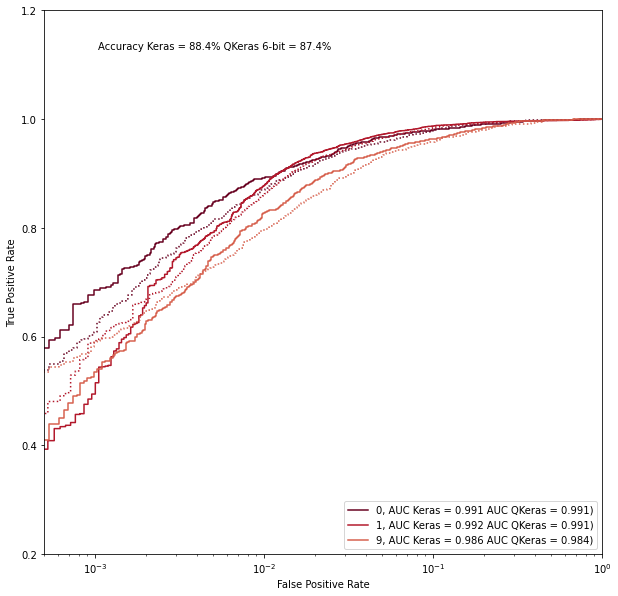

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics


# labels=['%i'%nr for nr in range (0,n_classes)] #If you want to look at all the labels
labels = ['0','1','9'] #Lets look at only a few labels, here for digits 0, 1 and 9
print('Plotting ROC for labels {}'.format(labels))

df = pd.DataFrame()
df_q = pd.DataFrame()
fpr  = {}
tpr  = {}
auc1 = {}
fpr_q  = {}
tpr_q  = {}
auc1_q = {}
%matplotlib inline
colors  = ['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']
fig = plt.figure(figsize=(10,10))
for i, label in enumerate(labels):
    df[label] = Y_test[:,int(label)]
    df[label + '_pred'] = predict_baseline[:,int(label)]
    fpr[label], tpr[label], threshold = metrics.roc_curve(df[label],df[label+'_pred'])
    auc1[label] = metrics.auc(fpr[label], tpr[label])
    
    df_q[label] = Y_test[:,int(label)]
    df_q[label + '_pred'] = predict_qkeras[:,int(label)]
    fpr_q[label], tpr_q[label], threshold_q = metrics.roc_curve(df_q[label],df_q[label+'_pred'])
    auc1_q[label] = metrics.auc(fpr_q[label], tpr_q[label])
    
    plt.plot(fpr[label],tpr[label]    ,label=r'{}, AUC Keras = {:.3f} AUC QKeras = {:.3f})'.format(label,auc1[label],auc1_q[label]), linewidth=1.5,c=colors[i],linestyle='solid')
    plt.plot(fpr_q[label],tpr_q[label], linewidth=1.5,c=colors[i],linestyle='dotted')

plt.semilogx()
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.xlim(0.0005,1.)
plt.ylim(0.2,1.2)
plt.legend(loc='lower right')
plt.figtext(0.2, 0.83,r'Accuracy Keras = {:.1f}% QKeras 6-bit = {:.1f}%'.format(test_score_baseline[1]*100,test_score_qkeras[1]*100), wrap=True, horizontalalignment='left',verticalalignment='center')
      

#     getSingleRoc(X_test, labels, Y_test, model_tmp)


The difference in AUC between the fp32 Keras model and the 6-bit QKeras model, is small, as we have seen for the previous examples. As a bonus exercise, you can find an exercise below where we use AutoQKeras to find the best heterogeneously quantized model, given a set of resource and accuracy constriants.

Now, let's compare the two models after logic synthesis!

### Deployment with hls4ml

In this part, we will take the two models we trained above (the floating-point 32 Keras model and the 6-bit QKeras model), and synthesize them with hls4ml. Although your models are probably in memory, let's load them from scratch. We need to pass the appropriate custom QKeras/pruning layers when loading, and remove the pruning parameters that were saved together with the model.

In [36]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper

model = tf.keras.models.load_model('pruned_cnn_model_best.h5',custom_objects={'PruneLowMagnitude': pruning_wrapper.PruneLowMagnitude,'QDense': QDense, 'QConv2DBatchnorm': QConv2DBatchnorm, 'QActivation': QActivation})
model  = strip_pruning(model)

qmodel = tf.keras.models.load_model('quantized_cnn_model_best.h5',custom_objects={'PruneLowMagnitude': pruning_wrapper.PruneLowMagnitude,'QDense': QDense, 'QConv2DBatchnorm': QConv2DBatchnorm, 'QActivation': QActivation})
qmodel  = strip_pruning(qmodel)

Now, we need to define the hls4ml and Vivado configurations. Two things will change with respect to what was done in the previous exercises. First, we will use ``IOType= 'io_stream'`` in the Vivado configuration.

**You must use ``IOType= 'io_stream'`` if attempting to synthesize a convolutional neural network.**

The CNN implementation in hls4ml is based on streams, which are synthesized in hardware as first in, first out (FIFO) buffers. A sliding window buffer is used to hold all elements of a kernel window that are needed to compute one output element. We pre-compute the positions in the sliding window where a given input element isused, and store this information as a binary mask.

This is illustrated  in the gif below. The example shows a 3x3 convolution over a 6x6 image. The left image shows the mask of each pixel (we represent this as a number) and the right image shows the contents of the internal sliding window (an array of FIFOs, corresponding to the 3x3 kernel).

![alt text](images/conv2d_animation.gif "The implementation of convolutional layers in hls4ml is based on streams")

Lastly, we will use ``['Strategy'] = 'Latency'`` for all the layers in the hls4ml configuration. If one layer would have >4096 elements, we sould set ``['Strategy'] = 'Resource'`` for that layer, or increase the reuse factor by hand. You can find examples of how to do this below.

In [46]:
import hls4ml
import plotting

hls4ml.model.optimizer.OutputRoundingSaturationMode.layers = ['Activation']
hls4ml.model.optimizer.OutputRoundingSaturationMode.rounding_mode = 'AP_RND'
hls4ml.model.optimizer.OutputRoundingSaturationMode.saturation_mode = 'AP_SAT'

#First, the baseline model
hls_config = hls4ml.utils.config_from_keras_model(model, granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<16,6>'
hls_config['Model']['ReuseFactor'] = 1

# Create an entry for each layer, here you can for instance change the strategy for a layer to 'resource' 
# or increase the reuse factor individually for large layers.
# In this case, we designed the model to be small enough for a fully parallel implementation 
# so we use the latency strategy and reuse factor of 1 for all layers.
for Layer in hls_config['LayerName'].keys():
    hls_config['LayerName'][Layer]['Strategy'] = 'Latency'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
#If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config)
  
cfg = hls4ml.converters.create_vivado_config()
cfg['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg['HLSConfig']  = hls_config
cfg['KerasModel'] = model
cfg['OutputDir']  = 'baseline_cnn/'
cfg['XilinxPart'] = 'xcu250-figd2104-2L-e'
  
hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()
#hls_model.build(csim=False, synth=True, vsynth=True)


Interpreting Model
Topology:
Layer name: input_2, layer type: Input
Layer name: batch_normalization_6, layer type: BatchNormalization
Layer name: conv_0, layer type: Conv2D
  -> Activation (linear), layer name: conv_0
Layer name: batch_normalization_7, layer type: BatchNormalization
Layer name: conv_act_0, layer type: Activation
Layer name: max_pooling2d_3, layer type: MaxPooling2D
Layer name: conv_1, layer type: Conv2D
  -> Activation (linear), layer name: conv_1
Layer name: batch_normalization_8, layer type: BatchNormalization
Layer name: conv_act_1, layer type: Activation
Layer name: max_pooling2d_4, layer type: MaxPooling2D
Layer name: conv_2, layer type: Conv2D
  -> Activation (linear), layer name: conv_2
Layer name: batch_normalization_9, layer type: BatchNormalization
Layer name: conv_act_2, layer type: Activation
Layer name: max_pooling2d_5, layer type: MaxPooling2D
Layer name: dense_0, layer type: Dense
  -> Activation (linear), layer name: dense_0
Layer name: batch_normalizat

In [47]:
# Then our QKeras model
hls_config_q = hls4ml.utils.config_from_keras_model(qmodel, granularity='name')
hls_config_q['Model']['ReuseFactor'] = 1
hls_config_q['LayerName']['output_softmax']['Strategy'] = 'Stable'
plotting.print_dict(hls_config_q)
  
cfg_q = hls4ml.converters.create_vivado_config()
cfg_q['IOType']     = 'io_stream' # Must set this if using CNNs!
cfg_q['HLSConfig']  = hls_config
cfg_q['KerasModel'] = model
cfg_q['OutputDir']  = 'baseline_cnn/'
cfg_q['XilinxPart'] = 'xcu250-figd2104-2L-e'
  
hls_model_q = hls4ml.converters.keras_to_hls(cfg_q)
hls_model_q.compile()
#hls_model.build(csim=False, synth=True, vsynth=True)

Interpreting Model
Topology:
Layer name: input_4, layer type: Input
Layer name: batch_normalization_18, layer type: BatchNormalization


Exception: ERROR: Unsupported layer type: QConv2DBatchnorm